In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os, sys, time
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /Users/sugiyamasunao/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


## power spectrum class

In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
%%time
power_b1.init_pklin(3.0)

CPU times: user 111 ms, sys: 4.32 ms, total: 116 ms
Wall time: 29.6 ms


In [5]:
%%time
power_b1.init_pkhalo()

CPU times: user 503 ms, sys: 9.5 ms, total: 513 ms
Wall time: 356 ms


In [6]:
%%time
k = np.logspace(-5.0, 3, 100)
pkhalo = power_b1.get_pkhalo_kz(k, 0.1)
pklin  = power_b1.get_pklin_kz(k, 0.1)

CPU times: user 4.14 ms, sys: 1.53 ms, total: 5.67 ms
Wall time: 6.5 ms


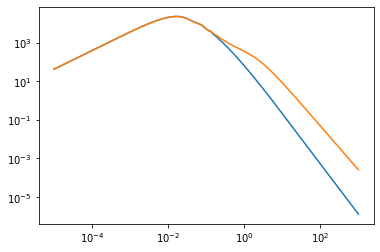

In [7]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e2,1e6)
plt.plot(k, pklin)
plt.plot(k, pkhalo)
plt.show()

$P\left(\frac{l}{\chi}, z(\chi)\right)$

In [8]:
l = 2e3
chimin, chimax = power_b1.z2chi(1e-4), power_b1.z2chi(3)
chi = np.logspace(np.log10(chimin), np.log10(chimax), 50)

In [9]:
%%time
pklin_lz = power_b1.get_pklin_lchi(l, chi)

CPU times: user 3.85 ms, sys: 597 µs, total: 4.45 ms
Wall time: 4.91 ms


In [10]:
%%time
pkhalo_lz = power_b1.get_pkhalo_lchi(l, chi)

CPU times: user 15.9 ms, sys: 2.02 ms, total: 17.9 ms
Wall time: 16.1 ms


In [11]:
%%time
pkhalogm_lz = power_b1.get_pkhalogm_lchi(l, chi, 4.0)

CPU times: user 17 ms, sys: 2.01 ms, total: 19 ms
Wall time: 17.3 ms


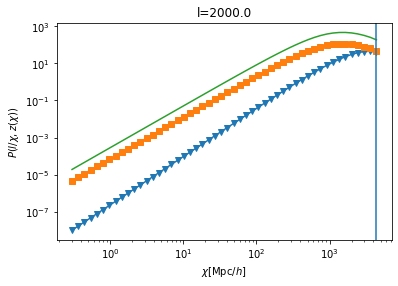

In [12]:
plt.figure()
plt.xlabel(r'$\chi[{\rm Mpc}/h]$')
plt.ylabel(r'$P\left(l/\chi, z(\chi)\right)$')
plt.title(f'l={l}')
plt.loglog(chi, pklin_lz, marker='v')
plt.loglog(chi, pkhalo_lz, marker='s')
plt.loglog(chi, pkhalogm_lz)#, marker='o')
plt.axvline(power_b1.chi_max)
plt.show()

## galaxy sample classes

In [13]:
g_l1 = hsc3x2pt.galaxy_sample_lens_class(['l1', 0.2, 0.2-0.01, 0.2+0.01, 2.1, 0.1, 2.3])
g_s1 = hsc3x2pt.galaxy_sample_source_class(['s1', 0.5, 0.2, 0.1])

In [14]:
cosmo_dict = power_b1.get_cosmo_dict()
g_l1.set_cosmology_from_dict(cosmo_dict)
g_s1.set_cosmology_from_dict(cosmo_dict)

chirange1 = g_l1.window_galaxy_chirange()
chirange2 = g_s1.window_lensing_chirange()

print(chirange1, chirange2)

[543.2862037  597.35429861] [  13.1496562 1301.815964 ]


In [15]:
g_l1.z_lens_eff

array(0.19983263)

In [16]:
hsc3x2pt.get_chirange_overlap(chirange1, chirange2)

array([543.2862037 , 597.35429861])

In [17]:
g_s1.sample_type

'source'

## $C(l)$ class

In [18]:
pk2cl = hsc3x2pt.pk2cl_class(power_b1)

In [19]:
pk2cl.set_cosmology_from_dict(cosmo_dict)
pk2cl.set_galaxy_sample(g_l1)
pk2cl.set_galaxy_sample(g_s1)
pk2cl.init_pk()

### $C(l)$ per single l

CPU times: user 54 ms, sys: 2.63 ms, total: 56.7 ms
Wall time: 54.9 ms


1.950968692801429e-07

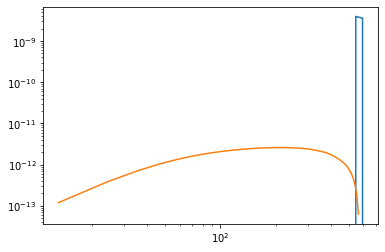

In [20]:
%%time
s1 = pk2cl.get_galaxy_sample('l1')
pk2cl._CgE(g_l1, g_s1, 100, model='nonlin', plot=True, plot_xlog=True)

CPU times: user 42.3 ms, sys: 2.8 ms, total: 45.1 ms
Wall time: 43.1 ms


1.123965200796944e-09

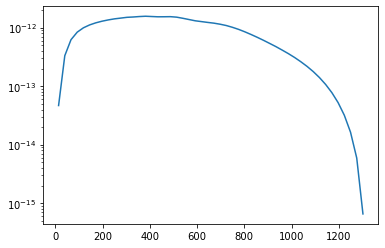

In [21]:
%%time
pk2cl._CEE(g_s1, g_s1, 100.0, model='nonlin', plot=True)

Cgg(l)                                =0.0005321748701783888
Cgg(l)+Cg,mag(l)                      =0.0005321848705815967
Cgg(l)+Cg,mag(l)+Cmag,g(l)            =0.0005321948709848046
Cgg(l)+Cg,mag(l)+Cmag,g(l)+Cmag,mag(l)=0.000532196514902018
CPU times: user 80.9 ms, sys: 3.72 ms, total: 84.6 ms
Wall time: 82.8 ms


0.000532196514902018

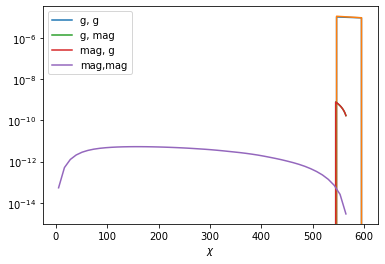

In [22]:
%%time
pk2cl._Cgg(g_l1, g_l1, 100.0, model='nonlin', plot=True)

### $C(l)$ as a function of $l$

lin:1.6536140441894531
nonlin:3.243499755859375


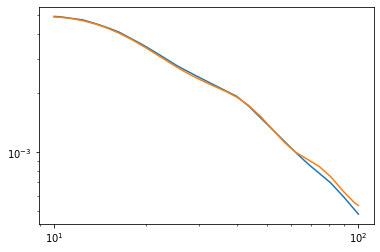

CPU times: user 5.27 s, sys: 65.7 ms, total: 5.34 s
Wall time: 5.34 s


In [23]:
%%time
l = np.logspace(1, 2.0, 1000)

plt.figure()
with hsc3x2pt.Time(message='lin'):
    clgg = pk2cl.Cgg('l1', 'l1', l, model='lin')
plt.loglog(l, clgg)
with hsc3x2pt.Time(message='nonlin'):
    clgg = pk2cl.Cgg('l1', 'l1', l, model='nonlin', plot=False)
plt.loglog(l, clgg)
plt.show()

lin:0.9942009449005127
lin:2.4161741733551025


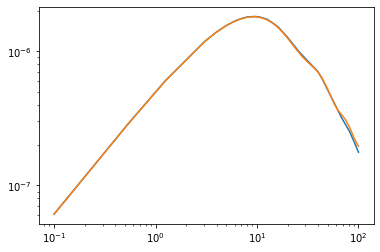

CPU times: user 4.02 s, sys: 69.5 ms, total: 4.09 s
Wall time: 4.11 s


In [24]:
%%time
l = np.logspace(-1, 2, 1000)

plt.figure()
with hsc3x2pt.Time(message='lin'):
    clgE = pk2cl.CgE('l1', 's1', l, model='lin')
plt.loglog(l, clgE)
with hsc3x2pt.Time(message='lin'):
    clgE = pk2cl.CgE('l1', 's1', l, model='nonlin')
plt.loglog(l, clgE)
plt.show()

lin:0.40083932876586914
lin:1.1014862060546875


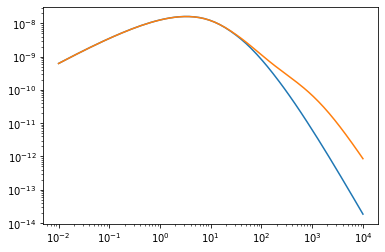

CPU times: user 2.47 s, sys: 37.4 ms, total: 2.51 s
Wall time: 2.52 s


In [25]:
%%time
l = np.logspace(-2, 4, 1000)

plt.figure()
t0 = time.time()
with hsc3x2pt.Time(message='lin'):
    clEE = pk2cl.CEE('s1', 's1', l, model='lin')
plt.loglog(l, clEE)
with hsc3x2pt.Time(message='lin'):
    clEE = pk2cl.CEE('s1', 's1', l, model='nonlin')
plt.loglog(l, clEE)
plt.show()

### compute all the $C(l)$

In [26]:
%%time
pk2cl.compute_all_Cl(l)

CPU times: user 5.75 s, sys: 49.6 ms, total: 5.8 s
Wall time: 5.81 s


In [27]:
pk2cl.dump_Cl_cache('temp_Cl', overwrite=True)

saving l to temp_Cl/l.txt
saving l1,l1 to temp_Cl/l1,l1.txt
saving l1,s1 to temp_Cl/l1,s1.txt
saving s1,s1 to temp_Cl/s1,s1.txt


In [28]:
pk2cl.load_Cl_cache('temp_Cl')

using dark_emulator at  /Users/sugiyamasunao/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


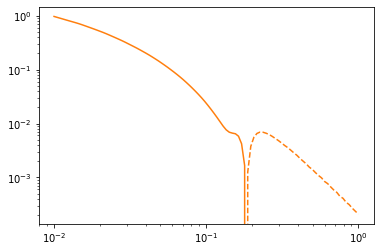

CPU times: user 776 ms, sys: 10.5 ms, total: 787 ms
Wall time: 792 ms


In [108]:
%%time

name1, name2 = 'l1', 'l1'
l = pk2cl.Cl_cache['Cl']['l']
Cl = pk2cl.Cl_cache['Cl'][ pk2cl.Cl_names_sep.join([name1, name2]) ]

t = np.logspace(-2, 0, 100)
dlnt = np.log(t[1]/t[0])

def helper(_t):
    dump = np.exp(-(l*_t)**2/(30*np.pi)**2)
    j = hsc3x2pt.jn_binave(0, l, _t, _t*np.exp(dlnt))
    ans = simps(l**2*Cl/2.0/np.pi * j * dump, np.log(l))
    return ans

ans = np.array([ helper(_t) for _t in t])

plt.figure()
plt.loglog(t, ans, c='C1')
plt.loglog(t,-ans, c='C1', ls='--')
plt.show()

using dark_emulator at  /Users/sugiyamasunao/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


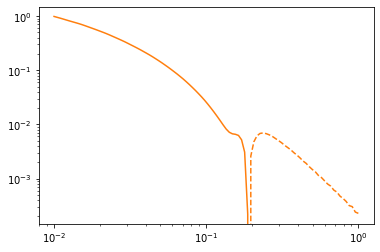

In [111]:
t = np.logspace(-2, 0, 100)
ans = pk2cl.angular_correlation_function_bruteforce(name1, name2, t, 'wp')

plt.figure()
plt.loglog(t, ans, c='C1')
plt.loglog(t,-ans, c='C1', ls='--')
plt.show()

In [96]:
_t = t[0]

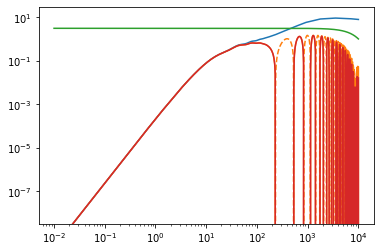

In [97]:
a = l**2*Cl/2.0/np.pi
j0 = hsc3x2pt.J0ave(l, _t, _t*np.exp(dlnt))
j2 = hsc3x2pt.J2ave(l, _t, _t*np.exp(dlnt))
j4 = hsc3x2pt.J4ave(l, _t, _t*np.exp(dlnt))
dump = np.exp(-(l*_t)**2/(30*np.pi)**2)

plt.figure()
plt.loglog(l, a)
plt.loglog(l, a*j0, c='C1')
plt.loglog(l,-a*j0, c='C1', ls='--')
ylim = plt.ylim()
plt.ylim(ylim[1]/1e10, ylim[1])
plt.loglog(l, dump*ylim[1]/10.0, c='C2')
plt.loglog(l, dump*a*j0, c='C3')
plt.show()

In [80]:
ylim

(1.78704567e-316, 6.210394046061209e+16)

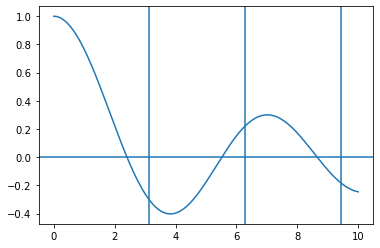

In [74]:
x = np.linspace(0, 10, 1000)
j = hsc3x2pt.jn(0, x)

plt.figure()
plt.axhline(0.0)
plt.plot(x, j)
plt.axvline(np.pi)
plt.axvline(2*np.pi)
plt.axvline(3*np.pi)
plt.show()